# NBA Draft Prediction Model - Kód Dokumentáció
## Könyvtárak importálása

A szükséges könyvtárak és modulok betöltése, amelyek az adatkezelés, gépi tanulás, hiperparaméter-tuning, 
és vizualizáció feladatait látják el. 

- **numpy és pandas**: Adatfeldolgozáshoz és manipulációhoz.
- **sklearn**: Adat előfeldolgozás (skálázás), adatbontás (train-test split) és modellek kiértékelése (MAE, R²).
- **tensorflow.keras**: A gépi tanulási modellek építésére, optimalizálására és kiértékelésére használjuk.
  - `Sequential` és `Model`: Modellek építésére.
  - Rétegek (`Dense`, `Dropout`, `Input`, `BatchNormalization`, `Lambda`): A modellek struktúrájának kialakítása.
  - Optimalizálók (`Adam`): A modellek tanulási algoritmusa.
- **matplotlib és seaborn**: Grafikus megjelenítésekhez, például scatter plotok és hőtérképek készítéséhez.
- **keras_tuner**: Hiperparaméterek optimalizálása a gépi tanulási modellhez.
- **tensorflow.keras.backend (K)**: Támogatási funkciók a TensorFlow belső használatához, például a `Lambda` réteg működtetéséhez.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
import seaborn as sns
import tensorflow.keras.backend as K

# Adatok betöltése és előkészítése

1. **Adatok betöltése CSV fájlokból**:
   - `drafted_players`: A 2009-2021 között draftolt játékosok adatait tartalmazza. A fájlt `;` szeparátorral olvassuk be.
   - `all_players_data`: Az összes egyetemi kosárlabdázó játékos adatait tartalmazza ugyanebből az időszakból.

2. **Adatok összekapcsolása és szűrése**:
   - `matched_players_data`: Összekapcsolja az összes játékos adatait a draftolt játékosokkal, közös oszlopok (például `player_name` és `pick`) alapján.
   - `players_data`: Eltávolítja a duplikált sorokat, így minden játékos egyszer szerepel a listában.

3. **Új jellemzők létrehozása**:
   - `pts_per_min`: Egy új oszlopot hoz létre, amely a játékosok pontszámait mutatja percenként, azaz `pts` és `Min_per` oszlopok hányadosát.

In [2]:
# Draftolt játékosok
drafted_players = pd.read_csv('DraftedPlayers2009-2021.csv', sep=';')
# Összes játékos
all_players_data = pd.read_csv('CollegeBasketballPlayers2009-2021.csv', low_memory=False)

# Mergelt gyűjtemény
matched_players_data = all_players_data.merge(drafted_players, on=['player_name', 'pick'], how='inner')
players_data = matched_players_data.drop_duplicates(subset=['player_name'], keep='last')


# Új jellemzők létrehozása
# Másolatot a DataFrame-ről
players_data = players_data.copy()
# Pontszám percenként (Points per minute)
players_data['pts_per_min'] = players_data['pts'] / players_data['Min_per']

# Adathalmaz rendezése és szétválasztása év alapján

1. **Adatok rendezése év szerint**:
   - `players_data_sorted`: A `players_data` adathalmazt rendezi a `year` oszlop szerint, így az adatok kronológiai sorrendben jelennek meg. Ez lehetővé teszi, hogy a későbbi elemzések és a modellépítés során az adatok időrendi szempontból is helyesen szerepeljenek.

2. **Tanító és validációs halmaz létrehozása**:
   - `train_val_data`: Ez a halmaz tartalmazza az összes olyan játékost, aki **nem 2015-ben** szerepelt a draftban. Ez a rész az adatokból szolgál a modell tanítására és validációjára.
   - (Alternatív lehetőségként a kommentben szereplő kódrészlet a 2014-es és 2019-es éveket is kizárja a tanító és validációs halmazból, ha a felhasználó ezekkel az évekkel szeretne különböző kísérleteket végezni. Jelenleg azonban nincs használatban.)

3. **Teszthalmaz létrehozása**:
   - `test_data`: Ez az adathalmaz kizárólag a **2015-ös év játékosait** tartalmazza, és a modell tesztelésére szolgál. A 2015-ös év választása biztosítja, hogy az adatok a tanító halmazból származóktól függetlenek legyenek, így az eredmények megbízhatóbbak.
   - (Egy másik, kommentelt kódrészlet a 2014-es és 2019-es éveket is használhatná teszthalmazként, ha a felhasználó több évet szeretne külön vizsgálni a modell tesztelése során. Ez azonban jelenleg ki van kapcsolva.)

---

Ez a struktúra biztosítja, hogy a modell ne csak egyetlen év adataira legyen érzékeny, hanem képes legyen általánosítani az időbeli eltéréseket is.

In [3]:
# Év szerinti sorrendben
players_data_sorted = players_data.sort_values(by='year')

#Tanító és validációs halmaz
train_val_data = players_data_sorted.loc[(players_data_sorted['year'] != 2015)]
#train_val_data = players_data_sorted.loc[(players_data_sorted['year'] != 2014) & (players_data_sorted['year'] != 2019)]

# Teszthalmaz
test_data = players_data_sorted.loc[(players_data_sorted['year'] == 2015)]
#test_data = players_data_sorted.loc[(players_data_sorted['year'] == 2014) | (players_data_sorted['year'] == 2019)]

# Korrelációs elemzés a célváltozóval (pick) való kapcsolat feltárásához

1. **Numerikus oszlopok kiválasztása**:
   - `numeric_features`: Kiválasztjuk a `train_val_data` adathalmaz összes numerikus oszlopát, kivéve a célváltozót (`pick`). Ez biztosítja, hogy csak a releváns prediktor változók kerüljenek bele az elemzésbe, amelyek elősegítik a célváltozóval való korreláció kiszámítását.

2. **Célváltozó hozzáadása a korreláció számításhoz**:
   - `numeric_features_with_target`: Készítünk egy másolatot a `numeric_features` adathalmazról, és hozzáadjuk a célváltozót (`pick`) az adatokhoz. Ez szükséges ahhoz, hogy a korrelációs mátrixban a célváltozó és a többi jellemző közötti kapcsolatot ki tudjuk mutatni.

3. **Korrelációs mátrix számítása**:
   - `correlation_with_target`: Kiszámítjuk a korrelációs mátrixot a `numeric_features_with_target` adathalmazban, de csak a célváltozó (`pick`) és a többi numerikus jellemző között. A célváltozóra vonatkozó sorokat töröljük, hogy csak a prediktorok és a célváltozó közötti kapcsolat maradjon meg.

4. **Hőtérkép megjelenítése**:
   - Megjelenítjük a korrelációs mátrixot egy hőtérképen, ahol:
     - A színek a korreláció irányát és mértékét jelölik (kék és piros árnyalatok).
     - Az annotációk a korrelációs értékeket mutatják két tizedes pontossággal, így a különböző jellemzők és a célváltozó közötti kapcsolat vizuálisan is jól látható.
   - A hőtérkép segít azonosítani azokat a jellemzőket, amelyek erősen pozitív vagy negatív kapcsolatban állnak a célváltozóval, ami hasznos lehet a modellépítés szempontjából.

---
Ez az elemzés betekintést nyújt a prediktorok és a célváltozó közötti kapcsolatokba, és segít meghatározni azokat a jellemzőket, amelyek erősebben befolyásolhatják a draft pick értékét.

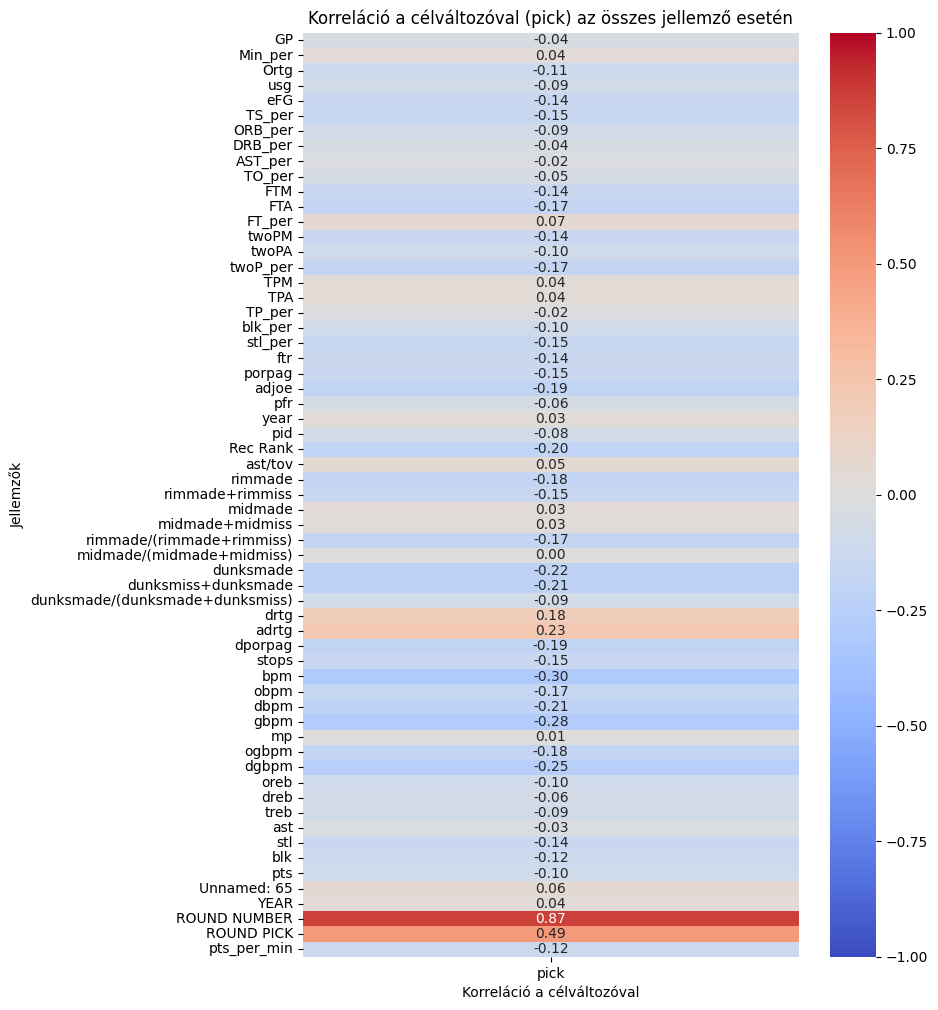

In [4]:
# Csak a numerikus oszlopokat választjuk ki, a célváltozó kivételével
numeric_features = train_val_data.select_dtypes(include=[float, int]).drop(columns=['pick'], errors='ignore')

# Hozzáadjuk a célváltozót
numeric_features_with_target = numeric_features.copy()
numeric_features_with_target['pick'] = train_val_data['pick']

# Korrelációs mátrix kiszámítása a célváltozóval
correlation_with_target = numeric_features_with_target.corr()['pick'].drop('pick')

# Hőtérkép a célváltozóval való korreláció alapján
plt.figure(figsize=(8, 12))
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Korreláció a célváltozóval (pick) az összes jellemző esetén')
plt.xlabel('Korreláció a célváltozóval')
plt.ylabel('Jellemzők')
plt.show()

# Legjobb jellemzők kiválasztása a célváltozóval való korreláció alapján

1. **Jellemzők szűrése korreláció szerint**:
   - `important_features`: Kiválasztjuk azokat a jellemzőket, amelyek korrelációs együtthatója abszolút értékben 0.1-nél nagyobb a célváltozóval (`pick`). Ez az abszolút korrelációs érték küszöb segít megtalálni azokat a jellemzőket, amelyek szorosabb kapcsolatban állnak a célváltozóval, akár pozitív, akár negatív irányban.
   
2. **Jellemzők listázása**:
   - Kiíratjuk az `important_features` listát, amely tartalmazza azokat a jellemzőket, amelyek a legjobban korrelálnak a célváltozóval. Ezek a jellemzők a modellépítés szempontjából különösen hasznosak lehetnek, mivel erősebb kapcsolatot mutatnak a célváltozóval.

---
Ez a lépés segít azonosítani azokat a legfontosabb jellemzőket, amelyek várhatóan jobban hozzájárulnak a modell pontosságához, mivel erősebben korrelálnak a célváltozóval.

In [5]:
# Kiválasztjuk azokat a jellemzőket, amelyek korrelációja abszolút értékben 0.2-nál nagyobb
important_features = correlation_with_target[abs(correlation_with_target) > 0.1].index.tolist()
print("Legjobb változók:", important_features)

Legjobb változók: ['Ortg', 'eFG', 'TS_per', 'FTM', 'FTA', 'twoPM', 'twoP_per', 'stl_per', 'ftr', 'porpag', 'adjoe', 'Rec Rank', 'rimmade', 'rimmade+rimmiss', 'rimmade/(rimmade+rimmiss)', 'dunksmade', 'dunksmiss+dunksmade', 'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'ogbpm', 'dgbpm', 'oreb', 'stl', 'blk', 'ROUND NUMBER', 'ROUND PICK', 'pts_per_min']


In [6]:
pd.set_option('display.max_rows', None)  # Minden sor kiírása
pd.set_option('display.max_columns', None)  # Minden oszlop kiírása (ha több oszlop is érdekel)


# Adatok rendezése év és pick szerint
sorted_players_data = players_data_sorted.sort_values(by=['year', 'pick'])

# Csak a szükséges oszlopok megjelenítése (év, név, pick)
result1 = train_val_data[['year', 'player_name', 'pick']]
result2 = test_data[['year', 'player_name', 'pick']]
result3 = sorted_players_data[['year', 'player_name', 'pick']]

# Kiírás a képernyőre
#print(result3)
#print(result1)
#print(result2)
#train_val_data.to_csv('result_train_val_data_withmask.csv', index=False)

# Célváltozó és Bemeneti Változók Kijelölése

1. **Bemeneti változók (features) kiválasztása**:
   - A `features` lista tartalmazza azokat a jellemzőket, amelyek inputként szolgálnak a modell számára. Ezek a jellemzők különböző kosárlabdázási statisztikai mutatókat reprezentálnak, mint például az `Ortg`, `eFG`, `TS_per`, `stl_per`, és `pts_per_min`.

2. **NaN értékek kezelése a bemeneti adatokban**:
   - Kijelöljük a bemeneti és célváltozókat:
     - `train_X`: Az `features` jellemzőket tartalmazza a tanító halmazból (`train_val_data`).
     - `test_X`: Az `features` jellemzőket tartalmazza a teszthalmazból (`test_data`).
     - `train_y`: A célváltozó (`pick`) a tanító halmazból.
     - `test_y`: A célváltozó (`pick`) a teszthalmazból.
   
3. **NaN értékek konvertálása**:
   - A NaN értékeket 0-ra konvertáljuk csak a bemeneti adatokban (`train_X` és `test_X`), hogy elkerüljük a modell tréning és predikció közbeni hibákat.

---
Ez a cella előkészíti a bemeneti és célváltozókat a modell számára, miközben kezeli a hiányzó értékeket is.

In [7]:
# Célváltozó és bemeneti változók kijelölése
features =  ['Ortg', 'eFG', 'TS_per', 'FTM', 'FTA', 'twoPM', 'twoP_per', 'stl_per', 
             'ftr', 'porpag', 'adjoe', 'drtg', 'adrtg', 'dporpag', 'stops',
             'bpm', 'obpm', 'dbpm', 'gbpm', 'ogbpm', 'dgbpm', 'oreb', 'stl', 'blk', 'pts_per_min']

# NaN értékek 0-ra konvertálása CSAK a bemeneti adatokban
train_X = train_val_data[features]
test_X = test_data[features]
train_y = train_val_data['pick']
test_y = test_data['pick']

# Adatok előkészítése és Pointwise Modell Hiperparaméter-tuningja

1. **Adatok szétválasztása tanító és validációs halmazra**:
   - Az adatok szétválasztására a `train_test_split` függvényt használjuk, 60 elem méretű validációs halmazt létrehozva.
   - `train_X`, `val_X`: A bemeneti változók a tanító és validációs halmazokban.
   - `train_y`, `val_y`: A célváltozók a tanító és validációs halmazokban.
   - `random_state=42` biztosítja az ismételhetőséget.

2. **Adatok skálázása**:
   - A `RobustScaler` használatával skálázzuk a tanító, validációs és teszt adatokat, hogy javítsuk a modell stabilitását és teljesítményét.
   - `train_X_scaled`, `val_X_scaled`, `test_X_scaled`: A tanító, validációs és teszt adatok skálázott változatai.

3. **Pointwise modell építése hiperparaméter-tuninggal**:
   - `build_pointwise_model(hp)`: Keras Tuner segítségével építjük a modellt, amely lehetővé teszi a hiperparaméterek optimalizálását.
   - A bemeneti réteg (`input_layer`) meghatározza a bemenet dimenzióját.
   - Rejtett rétegek és dropout rétegek kerülnek létrehozásra, amelyek mérete és dropout aránya a Keras Tuner által kerül optimalizálásra.
   - A kimeneti réteg (`output`) egy lineáris aktivációt alkalmazó Dense réteg, amely előrejelzi a célértéket.

4. **Hiperparaméter keresés Keras Tuner segítségével**:
   - `tuner`: A Keras Tuner `RandomSearch` osztályát használjuk a modell optimalizálására, amely a `build_pointwise_model` függvény alapján építi a modellt.
   - `objective='val_mae'`: A validációs MAE minimalizálása a cél.
   - `max_trials=10`, `executions_per_trial=2`: Maximálisan 10 próbálkozást engedélyez két futtatással minden egyes próbálkozásra.

---
Ez a cella előkészíti a tanító és validációs adatokat, skálázza azokat, és egy pointwise modellt épít, amely Keras Tuner segítségével optimalizálható a legjobb teljesítmény érdekében.

In [8]:
# Adatok szétválasztása tanító és validációs halmazra
train_X, val_X, train_y, val_y = train_test_split(train_val_data[features], train_val_data['pick'], test_size=60, random_state=42)

# Adatok skálázása (a meglévő kódod alapján)
scaler = RobustScaler()
train_X_scaled = scaler.fit_transform(train_X)
val_X_scaled = scaler.transform(val_X)
test_X_scaled = scaler.transform(test_X)

# Pointwise modell építése Keras Tuner segítségével
def build_pointwise_model(hp):
    input_shape = (train_X_scaled.shape[1],)
    input_layer = Input(shape=input_shape, name='input')
    
    # Rejtett rétegek a hyperparameter tuninggal
    x = input_layer
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu')(x)
        x = Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)
    
    # Kimeneti réteg
    output = Dense(1, activation='linear')(x)

    # Modell létrehozása
    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Hiperparaméter keresés Keras Tuner segítségével
tuner = kt.RandomSearch(
    build_pointwise_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='pointwise_model_tuning'
)

Reloading Tuner from my_dir\pointwise_model_tuning\tuner0.json


# Modell tréning és optimalizálás callbackekkel

1. **Callbackek beállítása a tanulás megállítására és a tanulási ráta csökkentésére**:
   - `es` (`EarlyStopping`): Monitorozza a validációs veszteséget (`val_loss`), és megállítja a tanulást, ha a veszteség 20 epochon keresztül nem javul. `restore_best_weights=True` paraméterrel visszaállítja a legjobb súlyokat.
   - `reduce_lr` (`ReduceLROnPlateau`): Csökkenti a tanulási rátát, ha a validációs veszteség 10 epochon keresztül nem javul. A tanulási ráta 0.2 faktorral csökken minden alkalommal, de nem csökken 1e-7 alá.

2. **Hiperparaméter keresés futtatása**:
   - `tuner.search()`: A Keras Tuner segítségével futtatja a hiperparaméter keresést a tanító halmazon (`train_X_scaled`, `train_y`), 100 epochon keresztül, validációs adatok (`val_X_scaled`, `val_y`) és a korábban beállított callbackek segítségével.

3. **Legjobb modell kiválasztása és újratanulása**:
   - `best_model`: Kiválasztja a legjobb teljesítményű modellt (`num_models=1`), amely a hiperparaméter keresés során a legalacsonyabb validációs MAE-t érte el.

---
Ez a cella a korábban definiált hiperparaméterekkel futtatja a tanulási folyamatot, majd kiválasztja a legjobb modellt a további felhasználásra.

In [9]:
# EarlyStopping és ReduceLROnPlateau callbackek
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7)

# Hiperparaméter keresés futtatása
tuner.search(train_X_scaled, train_y, epochs=100, validation_data=(val_X_scaled, val_y), callbacks=[es, reduce_lr])

# Legjobb modell kiválasztása és újratanulása
best_model = tuner.get_best_models(num_models=1)[0]

C:\Users\bszom\OneDrive\Desktop\Projektmunka\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# A legjobb modellek és hiperparaméterek összefoglalása

1. **Modell összegzése**:
   - `best_model.summary()`: Kiírja a legjobb modell rétegeit, azok paramétereit, valamint a neurális háló szerkezetét, beleértve a rétegek típusát és a neuronk számát. Ez segít áttekinteni a modell felépítését és a legoptimálisabb struktúrát.

2. **Legjobb hiperparaméterek lekérdezése**:
   - `best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]`: Lekérdezi a hiperparaméter keresés során legjobbnak talált hiperparaméter beállításokat. Az eredmény a legjobb próbálkozás (`num_trials=1`) során elért hiperparamétereket tartalmazza.

3. **Hiperparaméterek kiírása**:
   - `print(best_hp.values)`: Kiírja a legjobb hiperparaméterek értékeit. Ez magában foglalja a rétegek számát, az egyes rétegek neuron számait, a dropout arányt és a tanulási rátát, amelyeket a Keras Tuner optimalizált.

---
Ez a cella összegzi a hiperparaméter keresés eredményeit, beleértve a legjobb modell szerkezetét és a legjobbnak talált hiperparaméterek beállításait.

In [22]:
# Modell összesítése
# Legjobb modellek kiírása
#tuner.results_summary()
# A legjobb modell összefoglalása (struktúra, rétegek, neuronok száma stb.)
best_model.summary()


# A legjobb hiperparaméterek lekérdezése
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# A legjobb hiperparaméterek kiírása
print(best_hp.values)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 160)                 │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 352)                 │          22,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,697 (147.25 KB)

 Trainable params: 37,697 (147.25 KB)

 Non-trainable params: 0 (0.00 B)

{'num_layers': 3, 'units_0': 160, 'dropout_0': 0.30000000000000004, 'lr': 0.005229719005846043, 'units_1': 64, 'dropout_1': 0.1, 'units_2': 352, 'dropout_2': 0.30000000000000004}


# Modell kiértékelése és eredmények megjelenítése

1. **Előrejelzések generálása**:
   - `val_preds = best_model.predict(val_X_scaled)`: Előrejelzések készítése a validációs halmaz számára a legjobb modell alapján.
   - `test_preds = best_model.predict(test_X_scaled)`: Előrejelzések készítése a teszthalmaz számára a legjobb modell alapján.

2. **Kiértékelési metrikák számítása**:
   - `val_mae = mean_absolute_error(val_y, val_preds)`: A validációs halmaz átlagos abszolút hibájának (MAE) kiszámítása az előrejelzések és a valós értékek között. Az MAE az előrejelzések átlagos eltérését mutatja a valós értékekhez képest.
   - `val_r2 = r2_score(val_y, val_preds)`: A validációs halmaz R² értékének kiszámítása, amely a modell illeszkedésének mértékét adja meg. Az R² értéke 1-hez közelít, ha a modell jól teljesít.
   - `test_mae = mean_absolute_error(test_y, test_preds)`: A teszthalmaz átlagos abszolút hibájának (MAE) kiszámítása az előrejelzések és a valós értékek között.
   - `test_r2 = r2_score(test_y, test_preds)`: A teszthalmaz R² értékének kiszámítása.

3. **Eredmények megjelenítése**:
   - `print(f"Validation MAE: {val_mae}")`: A validációs MAE érték kiírása.
   - `print(f"Validation R²: {val_r2}")`: A validációs R² érték kiírása.
   - `print(f"Test MAE: {test_mae}")`: A teszt MAE érték kiírása.
   - `print(f"Test R²: {test_r2}")`: A teszt R² érték kiírása.

---
Ez a cella a legjobb modell teljesítményének kiértékelését végzi el, mind a validációs, mind a teszthalmaz esetében, az eredmények pedig a modell pontosságát és illeszkedését jelzik.

In [11]:
# Modell kiértékelése
val_preds = best_model.predict(val_X_scaled)
test_preds = best_model.predict(test_X_scaled)

val_mae = mean_absolute_error(val_y, val_preds)
val_r2 = r2_score(val_y, val_preds)
test_mae = mean_absolute_error(test_y, test_preds)
test_r2 = r2_score(test_y, test_preds)

# Eredmények megjelenítése
print(f"Validation MAE: {val_mae}")
print(f"Validation R²: {val_r2}")
print(f"Test MAE: {test_mae}")
print(f"Test R²: {test_r2}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Validation MAE: 8.994453525543213
Validation R²: 0.5080301474784779
Test MAE: 8.240730194818406
Test R²: 0.6052464262021787


# Validációs és Teszt Predikciók Rendezése és Kiírása

1. **Validációs predikciók tárolása és rendezése**:
   - `val_results_df`: Egy új DataFrame, amely tartalmazza a validációs halmaz eredeti adatait és a modell által készített előrejelzéseket.
     - `year`: Az eredeti adatok éve a validációs halmazban.
     - `player_name`: A validációs halmaz játékosainak nevei.
     - `true_pick`: A játékosok eredeti draft pozíciói.
     - `predicted_pick`: A modell által előrejelzett draft pozíciók, lapítva.
   - `val_results_df_sorted`: A `val_results_df` rendezve az `true_pick` oszlop alapján, az eredeti draft pozíciókat figyelembe véve.

2. **Validációs eredmények megjelenítése**:
   - Fejléc kiírása az oszlopok számára (`year`, `player_name`, `true_pick`, `predicted_pick`).
   - Egy `for` ciklus segítségével az összes rendezett sor kiírása, amely tartalmazza az évet, a játékos nevét, az eredeti és az előrejelzett draft pozíciókat.

3. **Teszthalmaz predikciók tárolása és rendezése**:
   - `test_results_df`: Egy új DataFrame, amely tartalmazza a teszthalmaz eredeti adatait és a modell által készített előrejelzéseket.
     - `year`: Az eredeti adatok éve a teszthalmazban.
     - `player_name`: A teszthalmaz játékosainak nevei.
     - `true_pick`: A játékosok eredeti draft pozíciói.
     - `predicted_pick`: A modell által előrejelzett draft pozíciók, lapítva.
   - `test_results_df_sorted`: A `test_results_df` rendezve az `true_pick` oszlop alapján, az eredeti draft pozíciókat figyelembe véve.

4. **Teszthalmaz eredmények megjelenítése**:
   - Fejléc kiírása az oszlopok számára (`year`, `player_name`, `true_pick`, `predicted_pick`).
   - Egy `for` ciklus segítségével az összes rendezett sor kiírása, amely tartalmazza az évet, a játékos nevét, az eredeti és az előrejelzett draft pozíciókat.

---
Ez a cella lehetővé teszi, hogy részletesen áttekintsük a validációs és teszthalmazra készült predikciókat, és összehasonlítsuk az eredeti és a predikált draft pozíciókat a modell teljesítményének jobb megértése érdekében.

In [12]:
# Validációs predikciók kiírása rendezve
val_results_df = pd.DataFrame({
    'year': train_val_data.loc[val_X.index, 'year'],  # Az eredeti adatok
    'player_name': train_val_data.loc[val_X.index, 'player_name'],  # Az eredeti adatok
    'true_pick': val_y,  # Eredeti validációs adatok
    'predicted_pick': val_preds.flatten()  # Nyers predikciók
})

val_results_df_sorted = val_results_df.sort_values(by='true_pick')

# Fejléc kiírása
print(f"{'year':<5} {'player_name':<25} {'true_pick':<10} {'predicted_pick':<15}")
print("-" * 60)
for _, row in val_results_df_sorted.iterrows():
    print(f"{row['year']:<5} {row['player_name']:<25} {row['true_pick']:<10} {row['predicted_pick']:<15}")

# Teszt predikciók rendezése
test_results_df = pd.DataFrame({
    'year': test_data['year'],  # Az eredeti adatok
    'player_name': test_data['player_name'],  # Az eredeti adatok
    'true_pick': test_y,  # Eredeti teszt adatok
    'predicted_pick': test_preds.flatten()  # Nyers predikciók
})

test_results_df_sorted = test_results_df.sort_values(by='true_pick')

# Fejléc kiírása
print(f"{'year':<5} {'player_name':<25} {'true_pick':<10} {'predicted_pick':<15}")
print("-" * 60)
for _, row in test_results_df_sorted.iterrows():
    print(f"{row['year']:<5} {row['player_name']:<25} {row['true_pick']:<10} {row['predicted_pick']:<15}")

year  player_name               true_pick  predicted_pick 
------------------------------------------------------------
2010  John Wall                 1.0        15.484233856201172
2012  Anthony Davis             1.0        9.113471031188965
2011  Derrick Williams          2.0        10.720354080200195
2016  Brandon Ingram            2.0        16.095003128051758
2021  Evan Mobley               3.0        8.874902725219727
2012  Harrison Barnes           7.0        14.512430191040039
2009  Gerald Henderson          12.0       19.457340240478516
2020  Kira Lewis Jr.            13.0       32.793582916259766
2020  Isaiah Stewart            16.0       34.74906539916992
2012  Royce White               16.0       22.43939971923828
2018  Donte DiVincenzo          17.0       15.997069358825684
2016  Henry Ellenson            18.0       23.4902400970459
2009  Jeff Teague               19.0       21.631473541259766
2018  Kevin Huerter             19.0       23.382997512817383
2021  Kai Jones   

# Validációs és Teszt Predikciók Scatter Plotok

1. **Validációs Predikciók Scatter Plot**:
   - `plt.figure(figsize=(10, 8))`: A scatter plot méretének beállítása.
   - `plt.scatter(val_y, val_preds, alpha=0.5)`: A validációs adatokból készített scatter plot, ahol az `x` tengelyen a valós (`val_y`), az `y` tengelyen pedig az előrejelzett (`val_preds`) draft pick értékek szerepelnek. Az `alpha=0.5` beállítás az átlátszóságot szabályozza.
   - `plt.title('Valós vs. Előrejelzett Draft Pick Értékek (Validációs halmaz)')`: A plot címe.
   - `plt.xlabel('Valós Draft Pick Érték')` és `plt.ylabel('Előrejelzett Draft Pick Érték')`: Az `x` és `y` tengely címkéi.
   - `plt.plot([val_y.min(), val_y.max()], [val_y.min(), val_y.max()], 'k--', lw=2)`: Egy fekete szaggatott vonalat rajzol az ideális előrejelzési vonalhoz (ahol a valós és az előrejelzett értékek megegyeznek).
   - `plt.show()`: A plot megjelenítése.

2. **Teszt Predikciók Scatter Plot**:
   - Hasonló a validációs predikciók scatter plotjához, de ez a teszthalmaz eredményeit ábrázolja.
   - `plt.scatter(test_y, test_preds, alpha=0.5)`: A teszt adatokból készített scatter plot, ahol az `x` tengelyen a valós (`test_y`), az `y` tengelyen pedig az előrejelzett (`test_preds`) draft pick értékek szerepelnek.
   - `plt.title('Valós vs. Előrejelzett Draft Pick Értékek (Teszthalmaz)')`: A plot címe.
   - `plt.xlabel('Valós Draft Pick Érték')` és `plt.ylabel('Előrejelzett Draft Pick Érték')`: Az `x` és `y` tengely címkéi.
   - `plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=2)`: Egy fekete szaggatott vonalat rajzol az ideális előrejelzési vonalhoz.

---

Ezek a scatter plotok segítenek vizuálisan értékelni a modell teljesítményét azáltal, hogy összehasonlítják a valós és az előrejelzett draft pick értékeket mind a validációs, mind a teszthalmazban. Az ideális eredmény az lenne, ha az összes pont a szaggatott vonal közelében helyezkedne el, ami azt jelzi, hogy az előrejelzések pontosak.

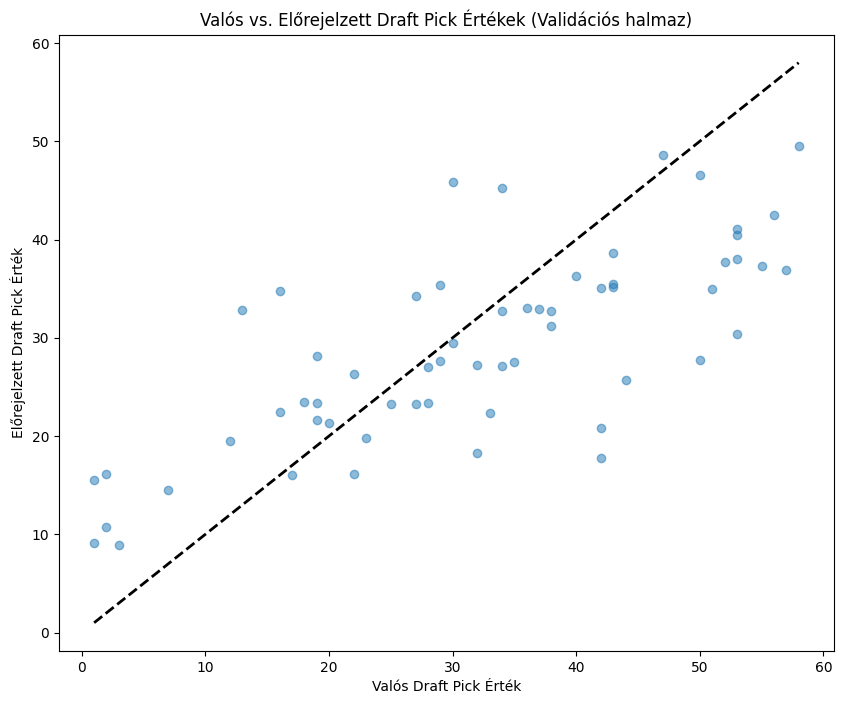

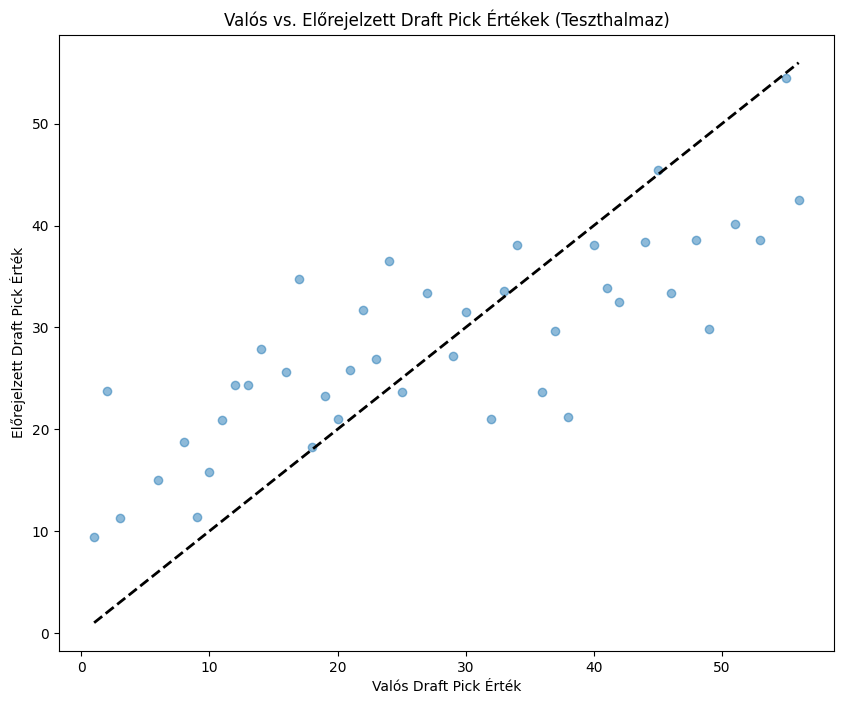

In [13]:
# Validációs predikciók scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(val_y, val_preds, alpha=0.5)
plt.title('Valós vs. Előrejelzett Draft Pick Értékek (Validációs halmaz)')
plt.xlabel('Valós Draft Pick Érték')
plt.ylabel('Előrejelzett Draft Pick Érték')
plt.plot([val_y.min(), val_y.max()], [val_y.min(), val_y.max()], 'k--', lw=2)
plt.show()

# Teszt predikciók scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(test_y, test_preds, alpha=0.5)
plt.title('Valós vs. Előrejelzett Draft Pick Értékek (Teszthalmaz)')
plt.xlabel('Valós Draft Pick Érték')
plt.ylabel('Előrejelzett Draft Pick Érték')
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=2)
plt.show()

# Hiányzó Draft Helyek Kezelése és Rangsor Meghatározása

1. **Teljes draft helyek listája**:
   - `all_positions = set(range(1, 61))`: Létrehoz egy listát az összes lehetséges draft helyről 1-től 60-ig.

2. **Jelenlegi helyek kiválasztása a teszthalmazban**:
   - `existing_positions = set(test_results_df['true_pick'].dropna().astype(int))`: Meghatározza a teszthalmazban lévő jelenlegi (valós) draft helyeket, és eltávolítja az esetleges NaN értékeket.

3. **Hiányzó helyek meghatározása**:
   - `missing_positions = all_positions - existing_positions`: Kiszámítja a hiányzó draft helyeket úgy, hogy kivonja a teszthalmaz jelenlegi helyeit a teljes listából.

4. **Hiányzó helyekhez tartozó sorok létrehozása**:
   - `missing_rows`: Egy új DataFrame, amely a hiányzó helyekhez tartozó sorokat tartalmazza. 
     - A `year` oszlop a teszthalmaz évét használja.
     - A `player_name` minden sorban `'Missing'`, hogy jelezze a hiányzó helyeket.
     - A `true_pick` oszlop tartalmazza a hiányzó helyeket.
     - A `predicted_pick` NaN értékeket tartalmaz, mivel ezekre a helyekre nincs predikció.

5. **Hiányzó helyek hozzáadása a teszthalmazhoz**:
   - `test_results_complete = pd.concat([test_results_df, missing_rows], ignore_index=True)`: Hozzáadja a hiányzó helyek sorait a teszthalmazhoz, majd rendezi őket a `true_pick` szerint.
   - `test_results_complete.sort_values(by='true_pick').reset_index(drop=True)`: Rendezi a teljes halmazt a `true_pick` alapján.

6. **Rangsor létrehozása meglévő játékosokra**:
   - `existing_ranks`: Rendezi azokat a sorokat, amelyeknek van predikciója (`predicted_pick`) és meghatározza a rangsorukat `predicted_order` néven.

7. **Kezdeti sorrend meghatározása**:
   - `test_results_complete.merge(...)`: Összekapcsolja a teljes teszthalmazt a meglévő rangsorral, így hozzáadva a `predicted_order` oszlopot a meglévő játékosokra.

8. **Hiányzó helyek hozzáadása a rangsorhoz**:
   - A hiányzó helyeket úgy adjuk hozzá, hogy frissítjük a `predicted_order` értékeket. Az új hiányzó hely minden egyes hozzáadásakor a meglévő rangsort tolja egy pozícióval, így a helyek a megfelelő sorrendben maradnak.

9. **Végső sorrend megjelenítése**:
   - `test_results_complete.sort_values(by='true_pick').reset_index(drop=True)`: Az egész DataFrame-et rendezi a `true_pick` alapján, és a végső sorrendet tartalmazza, beleértve a hiányzó helyeket is.
---
Ez a lépés biztosítja, hogy a hiányzó helyek megfelelően legyenek kezelve és az eredményül kapott rangsor teljes legyen, az eredeti draft helyeket figyelembe véve.

In [14]:
# Teljes draft helyek listája (1-től 60-ig)
all_positions = set(range(1, 61))

# Jelenlegi helyek a teszthalmazban
existing_positions = set(test_results_df['true_pick'].dropna().astype(int))

# Hiányzó helyek meghatározása
missing_positions = all_positions - existing_positions

# Létrehozzuk a hiányzó helyek sorait
missing_rows = pd.DataFrame({
    'year': [test_results_df['year'].iloc[0]] * len(missing_positions),
    'player_name': ['Missing'] * len(missing_positions),
    'true_pick': list(missing_positions),
    'predicted_pick': [np.nan] * len(missing_positions)  # Hiányzó helyek predikciója üres
})

missing_rows = missing_rows.dropna(axis=1, how='all')

# Hiányzó helyek hozzáadása a teszthalmazhoz, majd rendezés a `true_pick` alapján
test_results_complete = pd.concat([test_results_df, missing_rows], ignore_index=True)
test_results_complete = test_results_complete.sort_values(by='true_pick').reset_index(drop=True)

# A meglévő játékosok `predicted_pick` alapján rendezett sorrendje
existing_ranks = test_results_complete[~test_results_complete['predicted_pick'].isna()].sort_values(by='predicted_pick')
existing_ranks['predicted_order'] = np.arange(1, len(existing_ranks) + 1)

# Kezdeti sorrend meghatározása csak meglévő játékosokra
test_results_complete = test_results_complete.merge(existing_ranks[['true_pick', 'predicted_order']], 
                                                    on='true_pick', how='left')

# A hiányzó helyeket hozzáadjuk a `predicted_order` rangsorhoz
for missing_pos in sorted(missing_positions):
    # Minden hiányzó helyhez beszúrunk egy új rangsort a megfelelő helyen
    test_results_complete['predicted_order'] = test_results_complete.apply(
        lambda row: row['predicted_order'] + 1 if row['predicted_order'] >= missing_pos else row['predicted_order'], axis=1
    )
    # Hozzáadjuk a hiányzó pozíciót a saját eredeti pozíciójához
    test_results_complete.loc[test_results_complete['true_pick'] == missing_pos, 'predicted_order'] = missing_pos

# Végső sorrend megjelenítése a hiányzó helyekkel együtt
test_results_complete = test_results_complete.sort_values(by='true_pick').reset_index(drop=True)
#print(test_results_complete[['player_name', 'true_pick', 'predicted_pick', 'predicted_order']])

# Validációs és Teszthalmaz Eredmények Kiértékelése és Megjelenítése

1. **DataFrame létrehozása a validációs halmaz eredményeihez**:
   - `val_result_df`: Egy új DataFrame, amely a validációs halmaz eredményeit tartalmazza. Az oszlopok:
     - `player_name`: A validációs halmaz játékosainak nevei a `train_val_data` alapján.
     - `original_pick`: Az eredeti draft pick értékek (`val_y`).
     - `predicted_order`: A predikált sorrend, amelyet a `val_preds` alapján határozunk meg, rangsorolással (`np.argsort` segítségével).

2. **DataFrame létrehozása a teszthalmaz eredményeihez**:
   - `test_result_df`: Egy új DataFrame, amely a teszthalmaz eredményeit tartalmazza, beleértve a hiányzó helyeket is. Az oszlopok:
     - `player_name`: A játékos nevei és a "Missing" bejegyzések, ha a hely hiányzott az eredeti teszthalmazból.
     - `original_pick`: Az eredeti pick helyek (`true_pick`).
     - `predicted_order`: A rangsorolt predikciós sorrend (`predicted_order`), amely a hiányzó helyeket is figyelembe veszi.

3. **Játékosok sorrend szerinti megjelenítése**:
   - Validációs halmaz kiírása: A validációs adatok rendezett megjelenítése a `predicted_order` alapján, az első 60 sort kiíratva.
   - Teszthalmaz kiírása (hiányzó helyekkel): A teszthalmaz teljes rendezett kiírása, amely tartalmazza a hiányzó helyekkel kiegészített sorrendet.
---
Ezek a lépések lehetővé teszik a validációs és teszt eredmények részletes vizsgálatát, beleértve a predikált sorrendek összevetését az eredeti draft helyekkel.

In [23]:
# DataFrame a validációs halmaz eredményeire (nem változik)
val_result_df = pd.DataFrame({
    'player_name': train_val_data.loc[val_X.index, 'player_name'],
    'original_pick': val_y.values.flatten(),
    'predicted_order': np.argsort(np.argsort(val_preds.flatten())) + 1
})

# DataFrame a teszthalmaz eredményeire, a módosított rangsorral
test_result_df = pd.DataFrame({
    'player_name': test_results_complete['player_name'],
    'original_pick': test_results_complete['true_pick'],
    'predicted_order': test_results_complete['predicted_order']
})

# Játékosok sorrendben kiírása
print("Validációs halmaz:")
print(val_result_df.sort_values(by='predicted_order').head(60))

print("Teszthalmaz (hiányzó helyekkel):")
print(test_result_df.sort_values(by='predicted_order').head(60))

Validációs halmaz:
                player_name  original_pick  predicted_order
1323            Evan Mobley            3.0                1
603           Anthony Davis            1.0                2
346        Derrick Williams            2.0                3
520         Harrison Barnes            7.0                4
344               John Wall            1.0                5
975        Donte DiVincenzo           17.0                6
949          Brandon Ingram            2.0                7
335           Mason Plumlee           22.0                8
611          Pierre Jackson           42.0                9
1306       Vernon Carey Jr.           32.0               10
68         Gerald Henderson           12.0               11
84            Trevor Booker           23.0               12
845        Isaiah Whitehead           42.0               13
1287       Precious Achiuwa           20.0               14
55              Jeff Teague           19.0               15
1248           Daniel

# Grafikonok a Validációs és Teszthalmaz Eredményeihez

1. **Validációs Halmaz Grafikonja**:
   - **Ábra létrehozása**: A `plt.figure` beállítja a grafikon méretét (10x6).
   - **Oszlopdiagram készítése**:
     - Az `indices` változó az adatok indexeit tartalmazza, amely alapján az oszlopok helyezkednek el.
     - Két oszlopdiagram jön létre:
       - Az egyik az eredeti draft pick értékeket (`original_pick`) ábrázolja.
       - A másik a predikált sorrend értékeit (`predicted_order`) jeleníti meg.
     - Mindkét diagram a `predicted_order` alapján rendezett `val_result_df` adatait használja.
   - **Grafikon formázása**:
     - Cím: "Játékosok eredeti és prediktált draft értékei (Validációs)".
     - X-tengely: A játékosok nevei jelennek meg forgatva (`rotation=90`).
     - Jelmagyarázat, igazítás (`tight_layout`) és megjelenítés (`plt.show`).

2. **Teszthalmaz Grafikonja**:
   - **Ábra létrehozása**: Szintén 10x6-os méretben.
   - **Oszlopdiagram készítése**:
     - Két oszlopdiagram ábrázolja az eredeti pick értékeket és a predikált sorrendet a `test_result_df` alapján.
     - A `predicted_order` alapján rendezett adatok teszik lehetővé a hiányzó helyekkel kiegészített sorrend vizuális vizsgálatát.
   - **Grafikon formázása**:
     - Cím: "Játékosok eredeti és prediktált draft értékei (Teszthalmaz)".
     - X-tengely: Játékosok nevei, forgatva a jobb olvashatóság érdekében.
     - Jelmagyarázat, igazítás (`tight_layout`) és megjelenítés (`plt.show`).
---
Ez a vizualizáció segíti a predikciók és az eredeti pick helyek közötti különbségek vizsgálatát, mind a validációs, mind a teszthalmazra vonatkozóan.

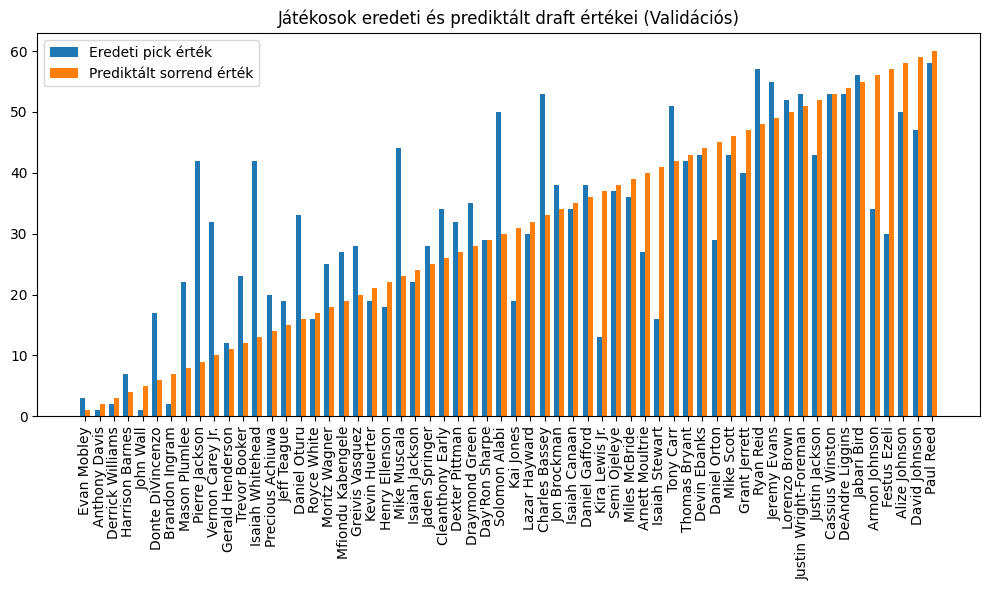

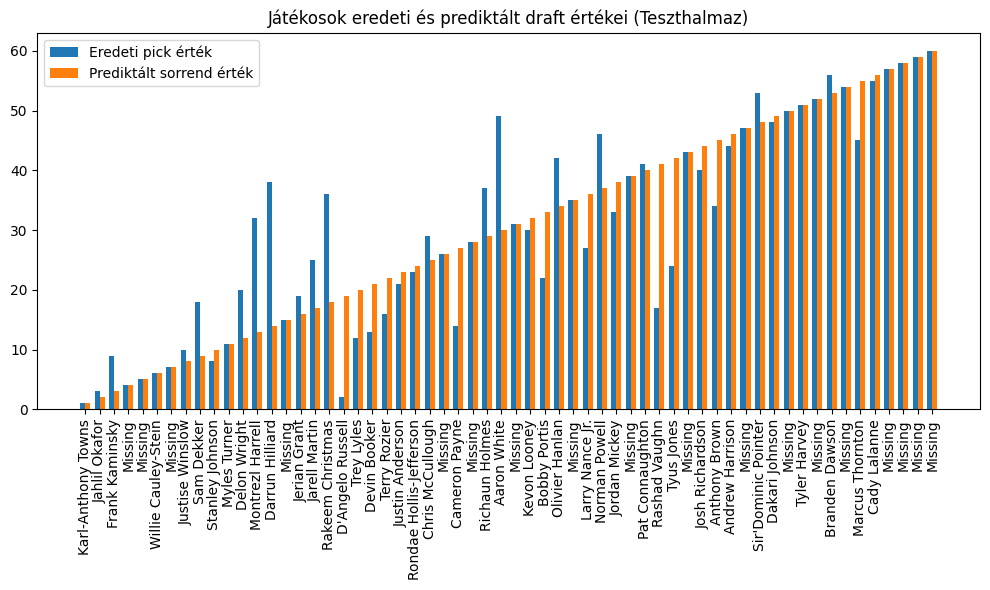

In [17]:
# Grafikonok validációs és teszthalmazra (külön rendezve)
plt.figure(figsize=(10, 6))  
bar_width = 0.35
indices = np.arange(len(val_result_df))
plt.bar(indices - bar_width/2, val_result_df.sort_values(by='predicted_order')['original_pick'], bar_width, label='Eredeti pick érték')
plt.bar(indices + bar_width/2, val_result_df.sort_values(by='predicted_order')['predicted_order'], bar_width, label='Prediktált sorrend érték')
plt.title('Játékosok eredeti és prediktált draft értékei (Validációs)')
plt.xticks(indices, val_result_df.sort_values(by='predicted_order')['player_name'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))  
indices = np.arange(len(test_result_df))
plt.bar(indices - bar_width/2, test_result_df.sort_values(by='predicted_order')['original_pick'], bar_width, label='Eredeti pick érték')
plt.bar(indices + bar_width/2, test_result_df.sort_values(by='predicted_order')['predicted_order'], bar_width, label='Prediktált sorrend érték')
plt.title('Játékosok eredeti és prediktált draft értékei (Teszthalmaz)')
plt.xticks(indices, test_result_df.sort_values(by='predicted_order')['player_name'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Eltérés Számítása és Rendezés

1. **Validációs Halmaz Eredményei**:
   - **DataFrame létrehozása**: A `val_result_df` tartalmazza a validációs halmaz játékosait, az eredeti (`original_pick`) és a predikált (`predicted_pick`) draft pick értékeket.
   - **Eltérés kiszámítása**: Az abszolút eltérés (`difference`) az `original_pick` és a `predicted_pick` közötti különbséget méri minden játékosnál.
   - **Rendezés**: A `val_result_df` játékosait a legkisebb eltérés alapján rendezzük, ami lehetővé teszi az eltérés szerinti elemzést.

2. **Teszthalmaz Eredményei**:
   - **DataFrame létrehozása**: A `test_result_df` a teszthalmaz játékosainak nevét, eredeti és predikált draft pick értékeit tartalmazza.
   - **Eltérés kiszámítása**: Az abszolút eltérés itt is a `difference` oszlopban jelenik meg, az eredeti és predikált értékek különbségeként.
   - **Rendezés**: A teszthalmaz eredményeit is a legkisebb eltérés szerint rendezzük, így kiemelve azokat a játékosokat, akiknél a predikció a legközelebb áll az eredeti értékhez.

3. **Eredmények kiírása**:
   - **Validációs Halmaz**: A validációs halmaz rendezett eredményeit a 60 legkisebb eltéréssel rendelkező játékos kiírásával jelenítjük meg.
   - **Teszthalmaz**: Hasonlóan, a teszthalmaz rendezett eredményei is megjelennek, szintén a legkisebb eltérések alapján.
---
Ez a kód lehetőséget ad arra, hogy a validációs és teszthalmazon belül könnyen áttekintsük, mely játékosok predikciója állt a legközelebb az eredeti draft pick értékükhöz.

In [24]:
# Eltérés kiszámítása és rendezés a validációs halmazra
val_result_df = pd.DataFrame({
    'player_name': train_val_data.loc[val_X.index, 'player_name'],  # Validációs játékosok
    'original_pick': val_y.values.flatten(),  # Eredeti pick érték
    'predicted_pick': val_preds.flatten()  # Nyers predikciók
})

# Abszolút eltérés az eredeti és predikált pick között
val_result_df['difference'] = np.abs(val_result_df['original_pick'] - val_result_df['predicted_pick'])

# Hasonló lépések a teszthalmazra
test_result_df = pd.DataFrame({
    'player_name': test_data['player_name'],  # Teszt játékosok
    'original_pick': test_y.values.flatten(),  # Eredeti pick érték
    'predicted_pick': test_preds.flatten()  # Nyers predikciók
})

# Abszolút eltérés az eredeti és predikált pick között
test_result_df['difference'] = np.abs(test_result_df['original_pick'] - test_result_df['predicted_pick'])

# Rendezzük a játékosokat a legkisebb eltérés alapján
val_result_sorted = val_result_df.sort_values(by='difference')

# Rendezzük a játékosokat a legkisebb eltérés alapján
test_result_sorted = test_result_df.sort_values(by='difference')

print("Validációs halmaz - Eltérés szerinti sorrend:")
print(val_result_sorted.head(60))

print("Teszthalmaz - Eltérés szerinti sorrend:")
print(test_result_sorted.head(60))

Validációs halmaz - Eltérés szerinti sorrend:
                player_name  original_pick  predicted_pick  difference
47            Lazar Hayward           30.0       29.433794    0.566206
1327         Jaden Springer           28.0       27.070822    0.929178
975        Donte DiVincenzo           17.0       15.997069    1.002931
383           Isaiah Canaan           34.0       32.692135    1.307865
1287       Precious Achiuwa           20.0       21.373318    1.373318
1328         Day'Ron Sharpe           29.0       27.611574    1.388426
1285          David Johnson           47.0       48.583546    1.583546
953           Moritz Wagner           25.0       23.229284    1.770716
55              Jeff Teague           19.0       21.631474    2.631474
1308          Miles McBride           36.0       33.056557    2.943443
84            Trevor Booker           23.0       19.771681    3.228319
1067          Alize Johnson           50.0       46.620327    3.379673
690           Grant Jerrett    

# Eltérés Grafikus Megjelenítése

1. **Validációs Halmaz Eltérései**:
   - **Grafikon létrehozása**: Egy oszlopdiagramot készítünk a validációs halmaz játékosainak abszolút eltéréseiről (`difference`), amely az eredeti és predikált draft pick értékek közötti különbséget mutatja.
   - **X-tengely**: A játékosok neveit tüntetjük fel.
   - **Y-tengely**: Az eltérés abszolút értékei láthatók.
   - **Cím és Elrendezés**: A diagram címe jelzi, hogy ez a validációs halmazra vonatkozik, és az x-tengely címkéit 90 fokkal elforgatjuk a jobb olvashatóság érdekében.

2. **Teszthalmaz Eltérései**:
   - **Grafikon létrehozása**: Hasonló oszlopdiagramot készítünk a teszthalmaz játékosainak eltéréseiről, szintén az abszolút különbségeket mutatva az eredeti és predikált értékek között.
   - **X- és Y-tengely**: Az x-tengelyen a játékosok nevei, az y-tengelyen pedig az eltérések abszolút értékei szerepelnek.
   - **Cím és Elrendezés**: A diagram címéből egyértelmű, hogy a teszthalmazt ábrázolja. Itt is elforgatjuk a címkéket, hogy könnyebben olvashatók legyenek.
---
Ezek az oszlopdiagramok segítenek vizualizálni, hogy mely játékosok esetében van a legnagyobb eltérés az eredeti és predikált értékek között, mind a validációs, mind a teszthalmazban.

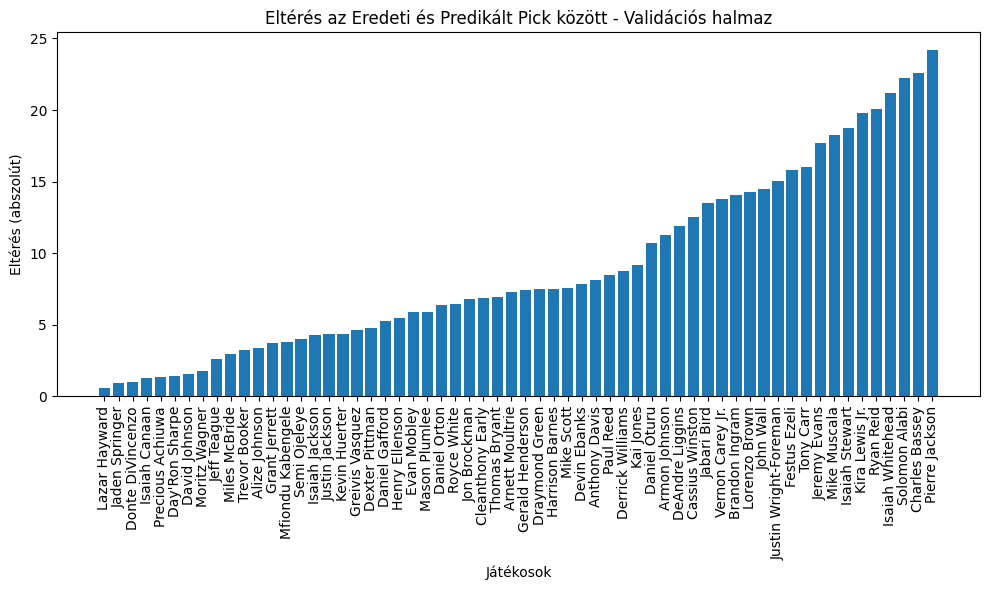

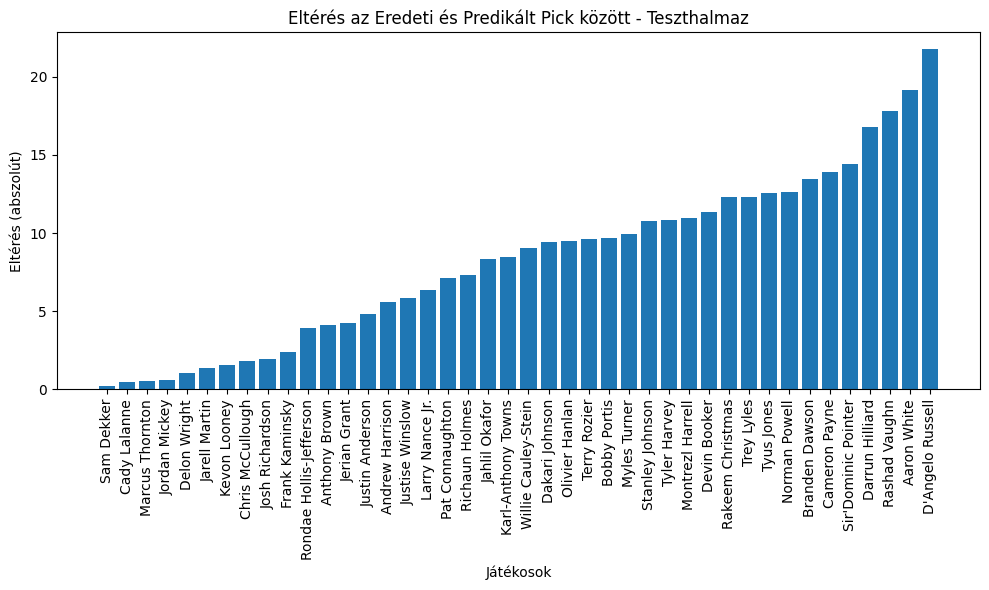

In [20]:
# Grafikon - Validációs halmaz
plt.figure(figsize=(10, 6))
plt.bar(val_result_sorted['player_name'], val_result_sorted['difference'])
plt.xlabel('Játékosok')
plt.ylabel('Eltérés (abszolút)')
plt.title('Eltérés az Eredeti és Predikált Pick között - Validációs halmaz')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Grafikon - Teszthalmaz
plt.figure(figsize=(10, 6))
plt.bar(test_result_sorted['player_name'], test_result_sorted['difference'])
plt.xlabel('Játékosok')
plt.ylabel('Eltérés (abszolút)')
plt.title('Eltérés az Eredeti és Predikált Pick között - Teszthalmaz')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()